## Relevance Check RAG 성능 높이기

#### 질문을 쪼개서 진행 
1. ~~질문을 구하고자하는 카테고리 단위로 쪼개서 질문~~
   - 관련성이 없다는 "no"만 뜨다가 끝남.  
   - `recursion_limit`=20로 설정하긴 함. (더 늘려봐도 될듯?)

#### RAG 설정 최적화 
1. Top-k 문서 수 증가  
2. 유사도의 임계값을 더 낮춰 많은 후보 문서를 가져오도록 한다. 
3. 검색된 여러 문서에서 유사도가 높은 부분만 결합해 답변을 생성하도록 모델을 조정
4. `FAISS` -> `Chroma` 
5. `similarity`
6. `mmr`
7. `similarity_score_threshold`

#### 임베딩
1. 임베딩을 bettery 관련 텍스트로 pre-trained 모델을 사용 -> bettery bert
2. ~~`OpenAIEmbeddings(model="text-embedding-3")` 사용~~
   - 기존에는 `OpenAIEmbeddings(model="text-embedding-ada-002")`
   - 동일한듯?

#### 위의 것들을 조합


In [1]:
import os 
import getpass

## retriever
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.document_loaders import PyPDFLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.vectorstores.base import VectorStoreRetriever

## Nodes and Edges
from langchain.prompts import PromptTemplate
from langchain_openai import ChatOpenAI
from langchain_core.output_parsers import StrOutputParser

## Graph
from langgraph.graph import END, StateGraph
from typing import Annotated, TypedDict
from langgraph.graph.message import add_messages

from langchain_teddynote.messages import messages_to_history
from langchain_core.documents.base import Document
from langchain_teddynote.evaluator import GroundednessChecker  

from langgraph.graph import END
from langgraph.checkpoint.memory import MemorySaver

from langchain_teddynote.graphs import visualize_graph

from langchain_core.runnables import RunnableConfig
from langchain_teddynote.messages import stream_graph, random_uuid

## logging
from langchain_teddynote import logging  

## API Key Setting

In [3]:
def _set_if_undefined(var: str):
    # 주어진 환경 변수가 설정되어 있지 않다면 사용자에게 입력을 요청하여 설정합니다.
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"Please provide your {var}")


# OPENAI_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("OPENAI_API_KEY")
# LANGCHAIN_API_KEY 환경 변수가 설정되어 있지 않으면 사용자에게 입력을 요청합니다.
_set_if_undefined("LANGCHAIN_API_KEY")

# LangSmith 추적 기능을 활성화합니다. (선택적)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "Multi-agent Collaboration"

In [4]:
logging.langsmith("VoltAI-Adjust-Top-k-Relevance-RAG")  

LangSmith 추적을 시작합니다.
[프로젝트명]
VoltAI-Adjust-Top-k-Relevance-RAG


In [2]:
input_data = "../paper_139.pdf"

## retriever(검색기) 생성

In [5]:
def embedding_file(file: str) -> VectorStoreRetriever:
    """문서를 청크 단위로 분할하고 임베딩 모델(text-embedding-ada-002)을 통해 임베딩하여 vector store에 저장합니다. 이후 vector store를 기반으로 검색하는 객체를 생성합니다. 

    Args:
        file (str): pdf 문서 경로

    Returns:
        VectorStoreRetriever: 검색기 
    """
    
    ## 긴 텍스트를 작은 청크로 나누는 데 사용되는 클래스
    splitter = RecursiveCharacterTextSplitter.from_tiktoken_encoder(       
        chunk_size=1500,         ## 최대 청크 길이 정의
        chunk_overlap=100,      ## 청크 간 겹침 길이 정의
        separators=["\n\n"]     ## 텍스트를 나눌 때 사용할 구분자를 지정 (문단)
    )
    
    ## PDF 파일 불러오기
    loader = PyPDFLoader(f"{file}")
    docs = loader.load_and_split(text_splitter=splitter)
    
    ## Embedding 생성 및 vector store에 저장
    embeddings = OpenAIEmbeddings()
    vector_store = FAISS.from_documents(
        documents=docs,         ## 벡터 저장소에 추가할 문서 리스트
        embedding=embeddings    ## 사용할 임베딩 함수
    )
    
    ## 검색기로 변환: 현재 벡터 저장소를 기반으로 VectorStoreRetriever 객체를 생성하는 기능을 제공
    retriever = vector_store.as_retriever(
        search_type="similarity",    ## 어떻게 검색할 것인지? default가 유사도
        search_kwargs={"k": 10}
    )

    return retriever

In [6]:
retriever = embedding_file(file=input_data)

In [24]:
outputs = retriever.invoke("""Below are instructions for filling out items by referring to the examples. The values shown to the right of the colon (“:”) are examples; please delete them after reviewing and rewrite them with the values found in the PDF. If any item is not mentioned in the PDF, do not remove it—write “None.”
1. Electrode (only coin cell)
1.1 Cathode active material: NCM-622
1.2 Lithium source: LiOH
1.3 Nickel supplied during the co-precipitation process of the precursor: NiSO4·6H2O
1.4 Cobalt supplied during the co-precipitation process of the precursor: CoSO4·7H2O
1.5 Manganese supplied during the co-precipitation process of the precursor: MnSO4·H2O
1.6 Co-precipitation solution: NaOH, 4M
1.7 Crystallization method (Hydrothermal or Sintering): Hydrothermal
1.8 Crystallization temperature: 100°C
1.9 Crystallization time: 12 hr
1.10 Active material : Conductive additive : Binder ratio: 90 : 5 : 5
1.11 Electrolyte: LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)
1.12 Doping: Zr4+ doping
1.13 Coating: ZrO2 coating
1.14 Additive: FEC 10% addition
1.15 Electrode thickness: 100 µm
1.16 only Cathode Electrode diameter: 14π
1.17 Loading density: 0.005 g/cm^2
1.18 Commercial NCM (check if specified in the paper): No
2. Cathode Performance
2.1 Capacity at all C-rate, mAh/g (with electrode state; e.g., coated or uncoated) : 214.5 mAh/g
2.2 Voltage range: 2.8–4.3 V
2.3 Temperature: Room temperature and 55°C
3. Cathode Equipment
3.1 Explanation of SEM results (indicate figure numbers as well):
ex) Fig. 2a, b;the NCM-622 seems to have more or less a spherical morphology with a diameter of 3–5 µm, composed of densely packed primary parti-cles
3.2 Explanation of TEM results: None""")

In [28]:
print(len(outputs))
print(outputs[1])

7
page_content='Fig. 4c gives cyclability of the pristine, FD-Al2O3-coated and HD-
Al2O3-coated NCR-CGS Li[Ni0.73Co0.12Mn0.15]O2 electrodes at a
current rate of 1 C between 3.0 and 4.3 V at room (25 /C14C) and
elevated (55 /C14C) temperatures. At room temperature, the pristine Li
[Ni0.73Co0.12Mn0.15]O2 electrode shows a steady decrease in
capacity throughout the cycling test, leading to a capacity
retention of 87.1% after 150 cycles. In contrast, the FD-Al2O3-
coated Li[Ni0.73Co0.12Mn0.15]O2 electrode is rather stable and
presents a remarkably enhanced capacity retention of 95.6% after
same cycles. At the elevated temperature, the pristine Li
[Ni0.73Co0.12Mn0.15]O2 electrode degrades more rapidly compared
with room temperature, which is due to the more severe side
reactions between the electrode and the electrolyte at higher
temperatures, leading to an increased formation of a nonconduct-
ing solid electrolyte interface (SEI) layer and even cell swelling
[28]. Nevertheless, as expected

In [18]:
# GraphState 상태 정의
class GraphState(TypedDict):
    question: Annotated[str, "Question"]  # 질문
    context: Annotated[str, "Context"]  # 문서의 검색 결과
    answer: Annotated[str, "Answer"]  # 답변
    messages: Annotated[list, add_messages]  # 메시지(누적되는 list)

In [19]:
def format_docs(docs: list[Document]) -> str:
    """문시 리스트에서 텍스트를 추출하여 하나의 문자로 합치는 기능을 합니다. 

    Args:
        docs (list[Document]): 여러 개의 Documnet 객체로 이루어진 리스트

    Returns:
        str: 모든 문서의 텍스트가 하나로 합쳐진 문자열을 반환
    """
    return "\n\n".join(doc.page_content for doc in docs)

# 문서 검색 노드
def retrieve_document(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 문서에서 검색하여 관련성 있는 문서를 찾습니다.
    retrieved_docs = retriever.invoke(latest_question)

    # 검색된 문서를 형식화합니다.(프롬프트 입력으로 넣어주기 위함)
    retrieved_docs = format_docs(retrieved_docs)

    # 검색된 문서를 context 키에 저장합니다.
    return GraphState(context=retrieved_docs)


# 답변 생성 노드
def llm_answer(state: GraphState) -> GraphState:
    # 질문을 상태에서 가져옵니다.
    latest_question = state["question"]

    # 검색된 문서를 상태에서 가져옵니다.
    context = state["context"]

    # prompt 설정
    prompt = PromptTemplate(
        template="""
        Based on the following document, please provide an answer to the given question.

        Document:
        {context}

        Question:
        {question}

        Answer:
        """,
        input_variables=["context", "question"],
        )
    
    # llm 호출
    llm = ChatOpenAI(
        model_name="gpt-4o",
        temperature=0, 
        streaming=True
        )
    
    # 체인 호출
    chain = prompt | llm | StrOutputParser()
    
    response = chain.invoke(
        {
            "question": latest_question,
            "context": context,
            "chat_history": messages_to_history(state["messages"]),
        }
    )
    
    # 생성된 답변, (유저의 질문, 답변) 메시지를 상태에 저장합니다.
    return GraphState(
        answer=response, 
        messages=[("user", latest_question), ("assistant", response)]
    )
    
    
# 관련성 체크 노드  
def relevance_check(state: GraphState) -> GraphState:  
    # 관련성 평가기를 생성합니다.  
    question_answer_relevant = GroundednessChecker(  
        llm=ChatOpenAI(model="gpt-4o", temperature=0), target="question-retrieval"  
    ).create()  

    # 관련성 체크를 실행("yes" or "no")  
    response = question_answer_relevant.invoke(  
        {"question": state["question"], "context": state["context"]}  
    )  

    print("==== [RELEVANCE CHECK] ====")  
    print(response.score)  

    # 참고: 여기서의 관련성 평가기는 각자의 Prompt 를 사용하여 수정할 수 있습니다. 여러분들의 Groundedness Check 를 만들어 사용해 보세요!  
    return GraphState(relevance=response.score)  


# 관련성 체크하는 함수(router)  
def is_relevant(state: GraphState) -> GraphState:  
    return state["relevance"] 

In [20]:
# 그래프 생성
workflow = StateGraph(GraphState)

# 노드 정의
workflow.add_node("retrieve", retrieve_document)
workflow.add_node("relevance_check", relevance_check)  
workflow.add_node("llm_answer", llm_answer)

# 엣지 정의
workflow.add_edge("retrieve", "relevance_check")  # 검색 -> 관련성 체크  

# 조건부 엣지를 추가합니다.  
workflow.add_conditional_edges(  
    "relevance_check",  # 관련성 체크 노드에서 나온 결과를 is_relevant 함수에 전달합니다.  
    is_relevant,  
    {  
        "yes": "llm_answer",  # 관련성이 있으면 답변을 생성합니다.  
        "no": "retrieve",  # 관련성이 없으면 다시 검색합니다.  
    },  
)  

# 그래프 진입점 설정
workflow.set_entry_point("retrieve")

# 체크포인터 설정
memory = MemorySaver()

# 컴파일
app = workflow.compile(checkpointer=memory)

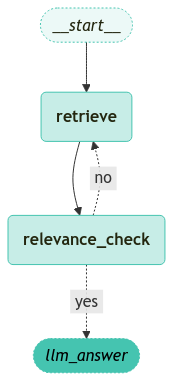

In [21]:
visualize_graph(app)

In [22]:
# config 설정(재귀 최대 횟수, thread_id)
config = RunnableConfig(recursion_limit=20, configurable={"thread_id": random_uuid()})

# 질문 입력
inputs = GraphState(question="""Below are instructions for filling out items by referring to the examples. The values shown to the right of the colon (“:”) are examples; please delete them after reviewing and rewrite them with the values found in the PDF. If any item is not mentioned in the PDF, do not remove it—write “None.”
1. Electrode (only coin cell)
1.1 Cathode active material: NCM-622
1.2 Lithium source: LiOH
1.3 Nickel supplied during the co-precipitation process of the precursor: NiSO4·6H2O
1.4 Cobalt supplied during the co-precipitation process of the precursor: CoSO4·7H2O
1.5 Manganese supplied during the co-precipitation process of the precursor: MnSO4·H2O
1.6 Co-precipitation solution: NaOH, 4M
1.7 Crystallization method (Hydrothermal or Sintering): Hydrothermal
1.8 Crystallization temperature: 100°C
1.9 Crystallization time: 12 hr
1.10 Active material : Conductive additive : Binder ratio: 90 : 5 : 5
1.11 Electrolyte: LiPF6 (EC, EMC, DEC mixture in a 1:1:1 volume ratio)
1.12 Doping: Zr4+ doping
1.13 Coating: ZrO2 coating
1.14 Additive: FEC 10% addition
1.15 Electrode thickness: 100 µm
1.16 only Cathode Electrode diameter: 14π
1.17 Loading density: 0.005 g/cm^2
1.18 Commercial NCM (check if specified in the paper): No
2. Cathode Performance
2.1 Capacity at all C-rate, mAh/g (with electrode state; e.g., coated or uncoated) : 214.5 mAh/g
2.2 Voltage range: 2.8–4.3 V
2.3 Temperature: Room temperature and 55°C
3. Cathode Equipment
3.1 Explanation of SEM results (indicate figure numbers as well):
ex) Fig. 2a, b;the NCM-622 seems to have more or less a spherical morphology with a diameter of 3–5 µm, composed of densely packed primary parti-cles
3.2 Explanation of TEM results: None""")

In [23]:
# 그래프 실행
stream_graph(
    graph=app, 
    inputs=inputs, 
    config=config, 
    node_names=["relevance_check", "llm_answer"]
)
outputs = app.get_state(config).values


🔄 Node: relevance_check 🔄
- - - - - - - - - - - - - - - - - - - - - - - - - 
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no
==== [RELEVANCE CHECK] ====
no


GraphRecursionError: Recursion limit of 20 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT